# Quick Start

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:


In [ ]:
%%capture --no-stderr
!pip install -U langgraph langsmith langchain_anthropic

In [ ]:
%%capture --no-stderr
!pip install --quiet -U  langchain_core langgraph
!pip install -U -q langchain
!pip install -U -q langchain_google_genai



Next, set your API keys:

In [ ]:
import os
from google.colab import userdata
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')   # to get langchain_api_key go smith.langchain.com then in settings create api and past it in jupyter notebook
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

google_api_key = userdata.get('GEMINI_API_KEY')


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", max_retries =2, api_key=google_api_key)
llm.invoke("greet me")

AIMessage(content='Hello there! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-f6c8a08d-ea3d-4cc5-a8bd-0c977d750612-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

## add_messages:
 add_messages function is likely responsible for appending new messages to the list of existing messages rather than replacing the list. So, each time you add a new message, it will be added to the current state without overwriting the existing messages.

In [ ]:
# the state will contain a messages list, and the add_messages function will handle how this list is updated.
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
def chatbot (state: State):
  #       key                     list of AI messages
  return {"messages" : [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot",chatbot)



In [ ]:
# Add an edge to transition from the 'START' state to the 'chatbot' state
graph_builder.add_edge(START, "chatbot")


In [ ]:
from langgraph.graph import END

# Now, we can work with the 'chatbot' state (e.g., add messages or handle logic)
graph_builder.add_edge("chatbot", END)  # Eventually, it can transition to 'END'

In [ ]:
graph = graph_builder.compile()

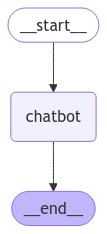

In [ ]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  # this requires some extra dependencies and is optional
  pass

In [ ]:
# graph.stream() is likely a method that returns an iterable (like a generator or stream). It takes an argument, in this case, a dictionary {"messages": [("user", "Iam a software engineer")]}
# An event is expected to be a dictionary or object that can be accessed using methods like .values().
for event in graph.stream({"messages": [("user", "Iam a software engineer")]}):
    print(event)
    print("EVENT:", list(event.values())[0]["messages"][-1].content)


{'chatbot': {'messages': [AIMessage(content="That's great! I'm glad to hear you're a software engineer.  It's a fascinating and challenging field.  \n\nTo help me understand your needs better, could you tell me more about:\n\n* **What kind of software do you develop?** (web apps, mobile apps, games, etc.)\n* **What programming languages do you use?** (Python, Java, C++, etc.)\n* **What are you working on right now?** (a specific project, a new skill, etc.)\n* **What are you interested in learning more about?** (new technologies, coding techniques, etc.)\n\nI'm here to help you in any way I can.  Whether you need help with coding, want to discuss industry trends, or just need someone to bounce ideas off of, I'm here for you. \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM

In [ ]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [("user", user_input)]}):
      for value in event.values():
        print("Assistant:", value["messages"][-1].content)


In [ ]:
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input)
  except:
    user_input = "What do you know about langGraph?"
    print("User:" + user_input)
    stream_graph_updates(user_input)
    break
    # Moreover you can go to smith.langchain.com & can check your conversational history in project under the name quickstart as we mentioned above.

User: My name is Hanry
Assistant: Nice to meet you, Hanry! Is there anything I can help you with today? 

User: My name please??
Assistant: I do not have access to personal information like your name. I am an AI and do not have memory of past conversations. 

Could you please tell me your name? 

User: q
Goodbye!


## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory," we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

1. First, install the requirements to use the [Tavily Search Engine](https://www.tavily.com), and set your `TAVILY_API_KEY` by signing in.



In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [ ]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

Next, define the tool:

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2) # maximum of 2 results from your query
tool.invoke("What is a node in langGraph")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [ ]:
tools = [tool] # When you have more than one tool, you can easily add them to this list.

## Defining Our Graph with Tools

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.


In [ ]:
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x790fcad00e80>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [ ]:
llm_with_tools.invoke("search pakistan and austrailia match schedule")
# As below mentioned the content is empty (content = ''), it means there is no response, and we need to automatically call the tool with the specified tool name and query.

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "pakistan and austrailia match schedule"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-58c8378c-f513-47a9-959a-ffc541e5cdac-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'pakistan and austrailia match schedule'}, 'id': '2d289161-b98c-46dc-9243-d19fe8a83c76', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 27, 'total_tokens': 109, 'input_token_details': {'ca

In [ ]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

tools_by_name["tavily_search_results_json"]

llm_with_tools.invoke("search using tool and what polls say about winner 2024 presidential elections")

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "what polls say about winner 2024 presidential elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-f05132a2-9514-4ff4-a3fd-14fa951fab7e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'what polls say about winner 2024 presidential elections'}, 'id': '2efcfa05-ddc3-4f88-b8fa-ff075315c844', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 31, 'total_tokens'

In [ ]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


In [ ]:
tools_by_name ["tavily_search_results_json"]


TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

## Strategy Explanation

### 1. Define the Class
First, we define a class (e.g., `BasicToolNode`) that will handle the logic for invoking tools. This class will receive a list of tools during initialization.

### 2. Check for Messages
After the class is defined, we will check whether the tools list contains any messages. Specifically, we will look for the `"messages"` key in the input data to ensure that there is something to process.

### 3. Verify AI Message
Once we confirm that messages are present, we check if the last message is an AI message. This is important because the tools should only be invoked in response to an AI-generated message, not user input or other types of messages.

### 4. Check for Tool Calls
If the message is indeed an AI message, the next step is to verify if the message contains any `tool_calls`. `tool_calls` represent the tools the AI message requests to invoke. If no tool calls are present, we should reject the request, as there’s nothing to process.

### 5. Map and Call the Tool
If `tool_calls` are present, we proceed by mapping each tool call to its corresponding tool. We search for the tool by name using the tool’s `name` attribute. If the tool is found, we call the tool’s `invoke()` method, passing the appropriate arguments.

### 6. Return the Results
After invoking the tool, we collect the results and return them. The results are typically wrapped in a response format, such as `ToolMessage`, that includes the tool’s output and relevant metadata (e.g., tool name, tool call ID).


A list of tools is passed to the constructor. Each tool is expected to have a name attribute and an invoke() method.



In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
#   passing tools
    def __init__(self, tools: list) -> None:       # The constructor creates a dictionary called tools_by_name where the key is the tool.name (a string), and the value is the actual tool object.
        #                                 maping
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):     # inputs is a dictionary that is expected to have a key called "messages", which is a list. If "messages" is not present, the function raises an error.
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []    # each message can contain one or more tool_calls. Each tool_call has:"name": The name of the tool to invoke."args": The arguments to pass to the tool."id": A unique identifier for the tool call.
        for tool_call in message.tool_calls:             # message.tool_callls meaning to get all the messages in tool such as name args and key. tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'pakistan and austrailia match schedule'}, 'id': 'e7291ddc-f321-43bd-b3b5-3cb496f745a3', 'type': 'tool_call'}]
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),   # content: The result of the tool call is converted to a JSON string.
                    name=tool_call["name"],  # name: The name of the tool that was invoked.
                    tool_call_id=tool_call["id"], # tool_call_id: The ID of the tool call, useful for tracking.
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node) # the tool node is added to the graph by using graph builder

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [
      AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "polls about 2024 presidential elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-6dfd11df-058d-438e-9f20-c24dd36e3bd0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'polls about 2024 presidential elections'}, 'id': '521fc765-89e4-486a-897a-772ec4a96980', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 28, 'total_tokens': 118, 'input_token_details': {'cache_read': 0}})
]
tool_node(inputs={"messages": messages})



{'messages': [ToolMessage(content='[{"url": "https://projects.fivethirtyeight.com/2024-election-forecast/", "content": "With the 2024 presidential election a week away, 538\'s Galen Druke and G. Elliott Morris discuss the relevancy of early voting data. October 29, 2024. The 2024 election could hinge on Pennsylvania. ... What the polls say about the 2024 election."}, {"url": "https://today.yougov.com/elections/us/2024", "content": "Explore YouGov\'s freely accessible data Discover our public data, featuring a diverse range of survey results, articles, trackers and popularity rankings. Get intelligence from our ever-growing source of consumer data on 27 million+ registered panel members in 55+ markets. Public Data Explore YouGov\'s freely accessible dataFor Business Helping the world\'s most recognised brands, media owners and agencies2024 Election Discover Key Insights on the U.S. Presidential Election 2024Sign in Sign up Explore YouGov\'s freely accessible data Discover our public dat

## Defining Conditional Edges

With the tool node added, we can define the conditional edges.

Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, we define a router function called `route_tools`, that checks for `tool_calls` in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt `tools_condition` to be more concise, but implementing it ourselves first makes things more clear.


## Conditional Edges and Graph Flow

Notice that conditional edges start from a single node. This tells the graph "any time the `chatbot` node runs, either go to `tools` if it calls a tool, or end the loop if it responds directly."

Like the prebuilt `tools_condition`, our function returns the `END` string if no tool calls are made. When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return `END`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

### Visualizing the Graph

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.


In [ ]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()


ValueError: Found edge starting at unknown node 'tools'

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

tools_conditional = route_tools  # Define tools_conditional as an alias for route_tools

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
tool_node = BasicToolNode(tools = [tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_conditional,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

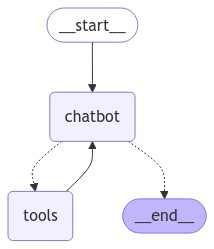

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what is the whethear in pakistan 
Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Islamabad', 'region': 'Islamabad', 'country': 'Pakistan', 'lat': 33.7, 'lon': 73.167, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1731185658, 'localtime': '2024-11-10 01:54'}, 'current': {'last_updated_epoch': 1731185100, 'last_updated': '2024-11-10 01:45', 'temp_c': 18.5, 'temp_f': 65.3, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 6.3, 'wind_kph': 10.1, 'wind_degree': 50, 'wind_dir': 'NE', 'pressure_mb': 1015.0, 'pressure_in': 29.99, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 43, 'cloud': 3, 'feelslike_c': 18.5, 'feelslike_f': 65.3, 'windchill_c': 18.5, 'windchill_f': 65.3, 'heatindex_c': 18.5, 'heatindex_f': 65.3, 'dewpoint_c': 5.7, 'dewpoint_f': 42.3, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.0, 'gust_mph': 13.2, 'gust_kph': 21.2}}"}, {"url": "https://nwfc.